# ARIMA_SVM组合预测

## 写在前面：

这是我的第二篇notebook，确实也渐渐喜欢上用它来记录代码了。之前为了练写作用英语写了一篇kaggle的houseprice解题过程，这一篇决定用中文把我的毕设论文记录下来，虽然毕设的方向的实际价值很小，但还是想把它写下来，毕竟也是用心特地自己写了代码求解问题的，而且在相关的问题上也有了新的见闻和想法。

这一篇文章主要研究的是某一个时期的黄金价格并预测，至于为什么研究黄金，也是我根据自己的喜好随便选的，自己更感兴趣的是研究的方法。因此，这毕竟是毕业论文，对于我不完全了解的更深入的机器学习算法还是不要碰太多为好。

另外，在写论文的过程中，我也发现在时间序列ARIMA的模型上，用eviews来处理可能更合适，因为可以更快更方便的看到结果；我在前期也尝试过用python来构建arima模型，发现过程比较繁琐，而且统计指标也不够全面。也可能那时我还不是很熟悉statsmodels库，以至于每一次调用都要去查资料。不过在这一个notebook中，我还是尽量用python代码来还原我的预测过程。

最后，由于本文与上一篇一样主要是分享自己写论文过程中真实的感悟，所以有一些口语化的语言并且排版也没有那么工整，希望读者适应。

## 一.需要用到的库

In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller as ADF
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.graphics.api import qqplot
from sklearn.svm import SVR
from sklearn.cross_validation import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import cross_val_score
from bayes_opt import BayesianOptimization

## 二.读取数据

本文数据主要来自国外的一个[网站](#https://fred.stlouisfed.org),这是美国圣路易斯联邦储备银行官方网站的数据库(找了半天才找到，不知道有没有更好的数据库网站)。选取的数据是2017年到2018年的每周黄金平均价格。当然，我也尝试过其他区间的数据，但是得到的预测结果总是显示R平方值不理想，这里也印证了仅仅根据过去的时间序列数据来预测未来并不可靠的想法，还是要利用多元数据来分析的，但是既然是毕业论文，当然就不去想这么多实际情况了。

先来看看数据的情况吧：

In [2]:
data=pd.read_csv('D:\dissertation\data3\gold1718w1.csv',index_col=0,parse_dates=True)
data.rename(columns={'GOLDPMGBD228NLBM':'Gold price'},inplace=True)
data['Gold price']=data['Gold price'].astype('float64')
#data

需要注意的是，为了防止差分或者残差定阶的时候出现缺失数据的问题，我们将多读取几个时期的数据以防万一，实际在建模时我们用到的数据区间为2017年1月6日到2018年1月5日，因此接下来将对数据做一个切分。

In [3]:
test=np.array(data[-5:])
train=data[6:len(data)-5]
#train

看一下需要分析的数据的时序图：

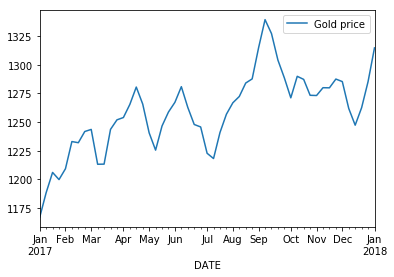

In [4]:
%matplotlib inline
train.plot()

## 三.ARIMA部分

### 3.1 平稳性

* __平稳性检验__

看一下自相关图

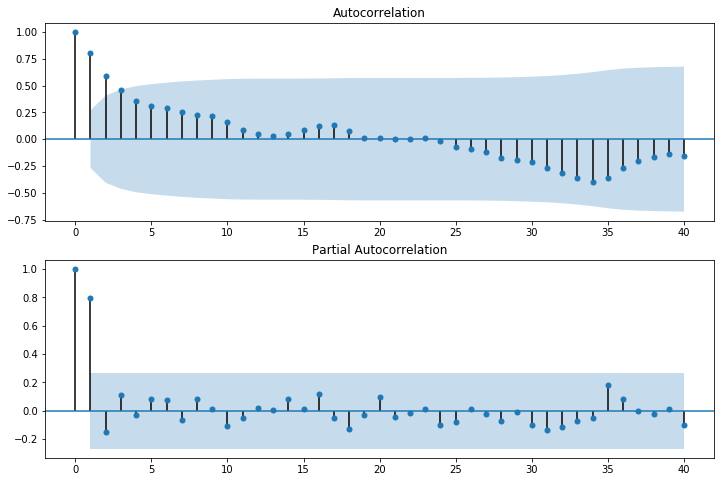

In [5]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(train, lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(train, lags=40, ax=ax2)

* __单位根检验：__

In [6]:
print('原始序列的ADF检验结果为： ', ADF(train['Gold price']))
#返回值依次为adf,pvalue,nobs,critical values,icbest,regresults,resstore

原始序列的ADF检验结果为：  (-2.0999976514548866, 0.24451554586451846, 2, 50, {'1%': -3.5684858639999999, '5%': -2.92135992, '10%': -2.5986615999999998}, 333.13854054493197)


单位根检验p值为0.2445，显然没有通过检验；而且两种自相关图都没有明显特征。所以综合来看原序列不平稳。

### 3.2 差分序列

先对原序列做一阶差分,并且看看差分后的时序图

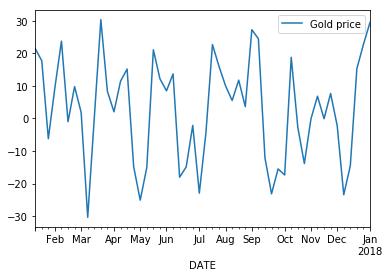

In [7]:
D_train=train.diff().dropna()
D_train.plot()

看上去还挺像平稳的，再看看两种自相关图

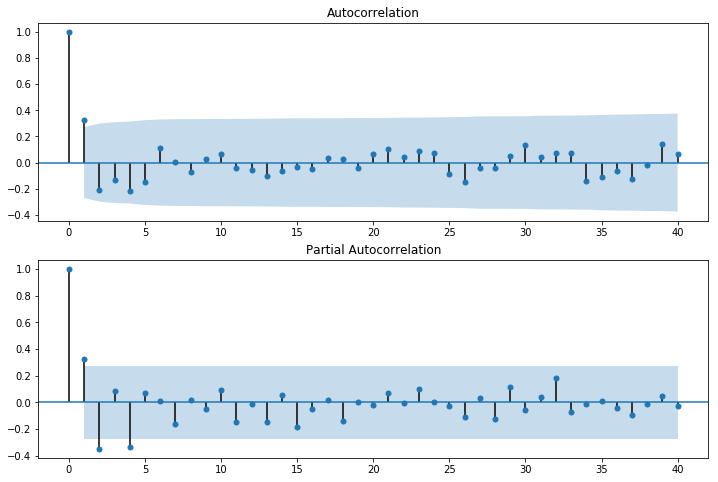

In [8]:
fig = plt.figure(figsize=(12,8))
ax3 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(D_train, lags=40, ax=ax3)
ax4 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(D_train, lags=40, ax=ax4)

单位根检验：

In [9]:
print('差分序列的ADF检验结果为： ', ADF(D_train['Gold price']))
#返回值依次为adf,pvalue,nobs,critical values,icbest,regresults,resstore

差分序列的ADF检验结果为：  (-4.9010024322722678, 3.4718012349130726e-05, 3, 48, {'1%': -3.5745892596209488, '5%': -2.9239543084490744, '10%': -2.6000391840277777}, 327.19717017824792)


单位根检验p值过关，两种自相关图也符合要求，就认为差分后的序列是平稳了的吧！

还有一个ljungbox检验，好像主要是看序列是不是白噪声，如果是白噪声的话是没有研究意义的

In [10]:
print('差分后序列的白噪声检验结果为： ', acorr_ljungbox(D_train, lags=1))  #返回统计量和p值

差分后序列的白噪声检验结果为：  (array([ 5.7236846]), array([ 0.01673757]))


p值检验通过，看来不是白噪声序列，可以进行后续分析。

### 3.3 模型定阶

模型定阶这一块我花了很多时间，因为自己感觉往上找的方法很多，而且判断标准不一，所以也想了很久。具体的做法我先看了一下两种自相关图，从自相关系数图来看，还是比较明显的，除了滞后1阶，其他都落在了置信区间内，所以直接定q=1或0；另一方面，偏自相关系数图就有三个地方超过置信区间内，所以大概有p=0,1,2,3,4可以考虑。这两个图还比较友好，可以比较方便的判断，之前找的一些数据在滞后8或9阶落在区间外的都有，所以再一次强调，选择的数据也挺关键的。

接下来要决定具体的p和q值，但是我们显然无法从两种自相关图得到。在论文里，我采用了其他很多个指标，包括Adjusted-R，AIC，SC，RMSE，MAPE，除了Adjusted-R，其他的指标都是越小越好。在这个地方，eviews就方便了许多，通过这个软件我们可以迅速得到每一个q和p对应的统计假设检验的结果，可以更加全面的判断哪个阶更合适，而python还是要手动码代码计算每一个统计指标。所以，我直接采用在eviews里表现最好的模型，也就是p=4和q=1。当然，我也会把我当初用python写的定阶过程的代码贴出来，就当是作为记录吧，它是以AIC为评判标准，不过这显然没有eviews全面。

In [11]:
#一共用了两种方法写代码
#方法一：
#res = sm.tsa.stattools.arma_order_select_ic(D_train, ic=['aic']) 
#print(res.aic_min_order)
#model = sm.tsa.ARMA(D_train, res.aic_min_order).fit(disp = 0)
#方法二：
#arma_mod11=sm.tsa.ARMA(D_train,(1,1)).fit()
#print(arma_mod11.aic,arma_mod11.bic,arma_mod11.hqic)
#arma_mod10=sm.tsa.ARMA(D_train,(1,0)).fit()
#print(arma_mod10.aic,arma_mod10.bic,arma_mod10.hqic)
#arma_mod01=sm.tsa.ARMA(D_train,(0,1)).fit()
#print(arma_mod01.aic,arma_mod01.bic,arma_mod01.hqic)
#......

拟合模型：

In [12]:
arma_mod41=sm.tsa.ARMA(D_train,(4,1)).fit()

### 3.4 模型的检验

根据正常的步骤，当然还是要对得到的模型进行检验啦(当初敲代码的时候，一直都在祈祷这些检验都能通过)。

* __显著性检验__

先看一下残差qq图：

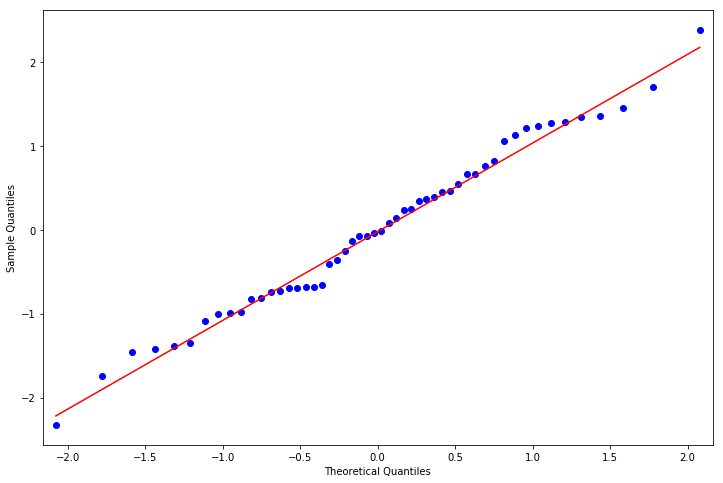

In [13]:
residue=arma_mod41.resid
fig=plt.figure(figsize=(12,8))
ax5=fig.add_subplot(111)
fig=qqplot(residue,line='q',ax=ax5,fit=True)

再看一下残差的情况：

In [14]:
r,q,p = sm.tsa.acf(residue.values.squeeze(), qstat=True)
n_data = np.c_[range(1,41), r[1:], q, p]
table = pd.DataFrame(n_data, columns=['lag', "AC", "Q", "Prob(>Q)"])
print(table.set_index('lag'))

            AC          Q  Prob(>Q)
lag                                
1.0   0.019502   0.020941  0.884939
2.0   0.006765   0.023511  0.988313
3.0  -0.034451   0.091525  0.992835
4.0   0.000719   0.091555  0.998984
5.0  -0.055992   0.278858  0.998022
6.0   0.108753   1.000832  0.985581
7.0  -0.167071   2.742581  0.907751
8.0  -0.016312   2.759562  0.948529
9.0  -0.113790   3.605102  0.935432
10.0  0.105360   4.347262  0.930325
11.0 -0.133625   5.570161  0.900452
12.0 -0.042969   5.699772  0.930454
13.0 -0.060733   5.965341  0.947405
14.0 -0.074037   6.370394  0.956275
15.0 -0.005946   6.373077  0.972777
16.0 -0.110798   7.330622  0.966350
17.0  0.064893   7.668472  0.973131
18.0  0.070887   8.083474  0.977368
19.0  0.006922   8.087552  0.985768
20.0  0.058734   8.390266  0.988955
21.0  0.081904   8.997902  0.989231
22.0 -0.059598   9.330363  0.991428
23.0  0.109731  10.496244  0.987765
24.0 -0.029789  10.585235  0.991677
25.0  0.052382  10.870595  0.993555
26.0 -0.177279  14.264820  0

最后是ljungbox检验：

In [15]:
print('序列的白噪声检验结果为： ', acorr_ljungbox(residue, lags=1))  #返回统计量和p值

序列的白噪声检验结果为：  (array([ 0.02094129]), array([ 0.884939]))


ljungbox检验p值远大于0.1，再综合之前的两幅图，可以认为是白噪声序列了。

* __参数显著性检验__

这一块当时不太会用python做，所以之后用eviews来观察结果的，所以还是用eviews方便一点啊......

### 3.5 预测及差分还原

这一步eviews上是直接帮你做了的，但是python需要手动还原，当初写的时候也是费了不少力，因为好像没有找到相关的python方法。

与此同时，在这里我们是用动态预测的方法，即每次预测其实我们只是对下一期的值进行预测；之前我曾经尝试过静态预测，进行根据预测值来预测下一时期的值，但是效果很差，所以这里就只能进行一步预测，这也可以看出来实际问题中，时间序列的模型不是个可靠的方法。我在论文中对未来五个时期进行了一步预测并比较。

还需要指出的是，从这里开始，预测的结果就与写论文时预测的结果不太一样了，因为论文中时间序列部分的预测我用的是eviews来完成的，所以拟合过程有一点点区别。不过我看了一下，最终预测的数据相差并没有很多，所以暂时就按python里的结果来吧，毕竟我们看的是过程！

In [16]:
predict_ts = arma_mod41.predict()
forecast_goldprice = arma_mod41.predict('2018-01-12', '2018-02-09', dynamic=True)
train_array=train['Gold price']
data_array=data['Gold price']
L=len(predict_ts)
K=len(forecast_goldprice)
i=0
t=1
j=1
while i<L:
    predict_ts[i]=predict_ts[i]+train_array[i]
    i=i+1
forecast_goldprice[0]=data_array[-6]+forecast_goldprice[0]
while j<K:
    forecast_goldprice[j]=forecast_goldprice[j]+data_array[-6+j]
    j=j+1

### 3.6 结果研究

首先看一下预测值与实际值的比较：

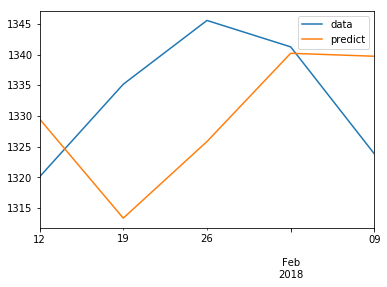

In [17]:
p1=pd.DataFrame({'data':test.ravel(),'predict':forecast_goldprice})
p1.plot()

模型的好坏我们用RMSE，MAPE来评价，先来看看ARIMA的结果：

In [18]:
def rmse(x,pred):
    if len(x)!=len(pred):
        print('lenth not equal!')
        exit(0)
    error=[]
    for i in range(len(x)):
        error.append((x[i] - pred[i])**2)
    val=sqrt(sum(error) / len(error))
    return val
print('arima模型的rmse值为：',rmse(test.ravel(),forecast_goldprice))

arima模型的rmse值为： 15.527624752270546


In [19]:
def mape(x,pred):
    if len(x)!=len(pred):
        print('lenth not equal!')
        exit(0)
    error=[]
    for i in range(len(x)):
        error.append(abs((x[i] - pred[i])/x[i]))
    val=sum(error)/len(error)
    return val*100
print('arima模型的mape值为：',mape(test.ravel(),forecast_goldprice))

arima模型的mape值为： 1.01763765917


## 四. SVR部分

### 4.1 提取残差数据

接下来，在ARIMA模型的基础上，我们加入SVM模型使用组合预测的方法。也就是说，利用ARIMA模型提起数据线性信息，再利用SVM模型来提取非线性信息，进行一个综合。实际上在阅读文献的过程中，我发现大致有两种组合预测方法，一种是并联型，也就是给单一的方法加上权重，有点类似我上一篇写的ensemble models里的stacking；另一种方法是串联型，就是用另一个模型来研究单一模型的残差，从而对残差来预测。在论文中，我主要用到的是后一种方法。

首先我们先得到ARIMA模型的残差序列。

In [20]:
resid=np.array(train_array[1:])-np.array(predict_ts)
res_train=resid.copy()
resid_forecast=test.ravel()-np.array(forecast_goldprice)
#resid

### 4.2 SVR残差定阶

对于ARIMA模型的残差，我们希望通过SVR模型来对它进行预测，但是首先，我们需要知道到底过去几个时期的残差会对下一个时期的残差产生影响，这个过程就相当于ARIMA模型的定阶过程。但是，我们并不像时间序列模型那样有很多统计量可以参考，所以就根据利用不同阶进行预测的效果来进行比较。具体的步骤我在论文中已经写了，因此直接摘录如下：

Step1 由于数据量较大，为方便计算，仅考虑10阶以内的情况，选定阶数k(k=1,2,…10)。       
Step2 从起始时间开始按顺序每次取k个按时间顺序排列的残差数据，并依次排列下来，将     
排列好的矩阵作为SVM模型的输入，每次取数据时的第k+1个数据作为模型的输出，并保留误差。     
Step3 利用交叉验证的方法，随机取80%的数据作为模型的训练集，剩余数据作为测试集，      
利用SVR模型训练后对测试集的结果进行预测。     
Step4 在选定阶数为k的情况下，记RMSE(k)为利用SVM模型对测试集预测后与真实残差数据的均方误差，若RMSE(k)小于RMSE(k+1),则停止循环并输出模型阶数k；反之，则继续增加阶数。

另外，在这里小小吐槽一下，有几篇关于SVR残差定阶过程的论文它们的文字描述都是几乎一样的，而且讲得也不详细，还是一些博客有用。

In [21]:
def OrderSelect(train):
    rbf_svr=SVR(kernel='rbf')
    temp=10000
    m=len(train)
    #data=pd.to_numeric(data['resid'], errors='coerce')
    #svr_data=np.array(data)
    for i in np.arange(2,10): 
        X=np.zeros((m-i,i))
        Y=np.zeros((m-i,1))
        for j in np.arange(i):
            X[:,j]=train[j:j+m-i]
        Y=train[i:]
        X_train,X_test,Y_train,Y_test=train_test_split(X,Y,random_state=33,test_size=0.2)
        rbf_svr.fit(X_train,Y_train)
        pred=rbf_svr.predict(X_test)
        error=Y_test-pred
        mse=np.sum(error*error)/len(error)
        if temp>mse:
            temp=mse
        else:
            n=i
            break
    return n

n=OrderSelect(res_train)
print('The best order is:',n)

The best order is: 3


最后确定的阶数为3，也就是说每个残差值会受到前面3项的影响。

### 4.3 参数寻优

对于SVR模型，参数也是非常重要的。在整个寻优过程中，我将使用两种方法，一种是网格搜索，这是我在论文中使用的方法，但是我在确定寻优区间时碰到的问题很棘手，当我把区间调大时每次得到的结果都会造成过拟合，也就是在对未来五个值预测时效果很明显的不好，最后就直接选择了‘合适’的区间来寻优(在这里有一点小小的‘作弊’,也是为了应付论文不想再推倒重来找其他数据了)；另一种方法是我在上一篇notebook中使用的方法，也就是BayesianOptimization，由于这是我后来才发现的好方法，所以没有在写论文的过程中尝试它，非常可惜，所以在这里特地来弥补一下遗憾。

* __网格寻优__

先把训练集和测试集准备好。

In [25]:
# 数据准备
resid1=np.concatenate((resid,resid_forecast),axis=0)
n=len(resid1)
X=np.zeros((n-3,3))
Y=np.zeros((n-3,1))
rbf_svr=SVR(kernel='rbf')
for j in np.arange(3):
    X[:,j]=resid1[j:j+n-3]
Y=resid1[3:]
Y=Y.reshape(-1,1)
ss_X=StandardScaler()
ss_Y=StandardScaler()
X = ss_X.fit_transform(X)
Y = ss_Y.fit_transform(Y)
Y=Y.ravel()
X_train=X[:n-8]
Y_train=Y[:n-8]
X_test=X[-5:]
Y_test=Y[-5:]


寻优过程我当初做得很繁琐，现在简化如下：

In [39]:
# 开始寻优
C_range = np.logspace(0,2,100)
gamma_range = np.logspace(-2,0,100)
#C_range = np.arange(25,30)
#gamma_range = np.arange(0.2,1,0.1)
param_grid = dict(gamma=gamma_range, C=C_range)
grid = GridSearchCV(rbf_svr, param_grid=param_grid,scoring='neg_mean_squared_error',cv=5,verbose=1)
grid.fit(X_train,Y_train)
print(grid.best_params_)

Fitting 5 folds for each of 10000 candidates, totalling 50000 fits
{'C': 1.0, 'gamma': 0.01}


[Parallel(n_jobs=1)]: Done 50000 out of 50000 | elapsed:  1.7min finished


偷偷测试一下结果：

In [55]:
#pred1=grid.predict(X)
pred=grid.predict(X_test)
aaa=np.linalg.norm(Y_test-pred,ord=2)
bbb=np.linalg.norm(Y_test,ord=2)
print(aaa,bbb)
#拟合预测
#rbf_svr.fit(X_train,Y_train)
#pred=rbf_svr.predict(X_test)
#pred1=rbf_svr.predict(X)
#error=Y_test-pred
#mse=np.sum(error*error)/len(error)

2.59916403316 2.62346158664


其实当初在寻优的过程中，我对两个参数寻优范围的确定十分头疼，因为有试过好几个区间，发现如果把寻优范围设置得过大会使得模型拟合的效果不太理想(当然在这里我也‘作弊’了，将预测结果与实际的数据进行了对比)，不理想的结果是每一次的预测值绝对值都特别小，。所以我也是尝试了好几次才在论文里定了C∈[25,100],γ∈[0.2,1]的范围，在实际问题中这么做肯定是有问题的。

在寻优过程中，还有一点收获就是还是要进行归一化或者标准化的，因为不过不做就可能会造成预测值几乎是常数的问题，这个问题当初也困扰了我挺久。但是，在标准化后我还是遇到预测值为常数的问题，这个问题我到现在也没想到解决办法，可能是参数的设置范围太大导致的。

* __贝叶斯寻优__

具体寻优原理和过程已经在上一篇notebook中介绍过了，这里只贴出代码和结果，可以注意到的是，其实贝叶斯寻优与网格寻优算法差不多，但是却快很多，在我看来确实是个节约时间的好办法。

In [72]:
def svrcv(C, gamma,epsilon):
    val = cross_val_score(SVR(C=C, gamma=gamma, epsilon=epsilon), X_train, Y_train, 'neg_mean_squared_error', cv=5).mean()
    return val

if __name__ == "__main__":
    gp_params = {"alpha": 1e-5}

    svrBO = BayesianOptimization(svrcv,
        {'C': (0.1, 100), 'gamma': (0.01, 10), 'epsilon': (0.01,0.1)})
    #svcBO.explore({'C': [0.001, 0.01, 0.1], 'gamma': [0.001, 0.01, 0.1]}, 'epsilon':[])

    svrBO.maximize(n_iter=20, **gp_params)

    print('Final Results')
    print('SVR: %f' % svrBO.res['max']['max_val'])
    print(svrBO.res['max']['max_params'])

Initialization
-----------------------------------------------------------------
 Step |   Time |      Value |         C |   epsilon |     gamma | 
    1 | 00m00s |   -1.02509 |   19.7946 |    0.0551 |    5.1273 | 
    2 | 00m00s |   -0.98895 |   99.5772 |    0.0442 |    7.2926 | 
    3 | 00m00s |   -0.97875 |   88.7929 |    0.0968 |    9.9104 | 
    4 | 00m00s |   -0.98607 |    2.5266 |    0.0941 |    7.5532 | 
    5 | 00m00s |   -1.01689 |   99.4064 |    0.0751 |    5.3635 | 
Bayesian Optimization
-----------------------------------------------------------------
 Step |   Time |      Value |         C |   epsilon |     gamma | 
    6 | 00m04s |   -0.97939 |   12.3915 |    0.0100 |   10.0000 | 
    7 | 00m04s |   -0.97871 |   99.9464 |    0.0632 |    9.9871 | 
    8 | 00m05s |   -0.98822 |    0.1000 |    0.1000 |   10.0000 | 
    9 | 00m05s |   -0.97939 |   58.4095 |    0.0100 |   10.0000 | 
   10 | 00m04s |   -0.97917 |   72.2641 |    0.0250 |    9.9999 | 
   11 | 00m04s |   -0.97900

D:\python\Anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ -6.06975130e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 47, 'nit': 5, 'warnflag': 2}
  " state: %s" % convergence_dict)
D:\python\Anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([  2.61083777e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 48, 'nit': 4, 'warnflag': 2}
  " state: %s" % convergence_dict)


   17 | 00m11s |   -0.97872 |   99.9535 |    0.0623 |    9.9873 | 
   18 | 00m11s |   -0.97939 |   80.6770 |    0.0100 |   10.0000 | 


D:\python\Anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([  4.66128910e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 50, 'nit': 4, 'warnflag': 2}
  " state: %s" % convergence_dict)


   19 | 00m13s |   -0.98822 |    0.1000 |    0.1000 |   10.0000 | 
   20 | 00m09s |   -0.97939 |   50.9965 |    0.0100 |   10.0000 | 
   21 | 00m14s |   -0.97862 |  100.0000 |    0.1000 |   10.0000 | 


D:\python\Anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ -1.54626177e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 54, 'nit': 5, 'warnflag': 2}
  " state: %s" % convergence_dict)


   22 | 00m11s |   -0.97939 |   80.4799 |    0.0100 |   10.0000 | 


D:\python\Anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ -3.31781262e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 49, 'nit': 5, 'warnflag': 2}
  " state: %s" % convergence_dict)
D:\python\Anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([  1.58732905e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 45, 'nit': 3, 'warnflag': 2}
  " state: %s" % convergence_dict)


   23 | 00m12s |   -0.97939 |  100.0000 |    0.0100 |   10.0000 | 


D:\python\Anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([  1.33501017e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 46, 'nit': 4, 'warnflag': 2}
  " state: %s" % convergence_dict)


   24 | 00m13s |   -0.97870 |   99.9983 |    0.0626 |    9.9981 | 
   25 | 00m13s |   -0.97862 |   71.6323 |    0.1000 |   10.0000 | 


D:\python\Anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([  1.64932135e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 52, 'nit': 6, 'warnflag': 2}
  " state: %s" % convergence_dict)


Final Results
SVR: -0.978623
{'C': 99.814734399585703, 'gamma': 9.9988546145404502, 'epsilon': 0.086138750085436089}


再偷偷测试一下结果如下，看上去效果差了一点，其实也是需要一些运气的，因为数据量和维度都十分小而且每次寻优结果都不一样。

In [73]:
svr=SVR(C=99.814734,epsilon= 0.086,gamma=9.9988546)
svr.fit(X_train,Y_train)
pred=svr.predict(X_test)
ccc=np.linalg.norm(Y_test-pred,ord=2)
print(ccc,bbb)

2.65454680574 2.62346158664


### 4.4 组合预测的结果

最后的步骤就是把预测的残差再代回去来作为最终预测结果，由于整个过程比较简单，所以求解过程就省略了......

## 总结

综合看了一下整个过程，的确没有做到理想的结果，但是却给我的研究提供了不错的思路。并联式的组合预测方法确实是个不错的思想，但是受限于本篇文章中的数据量太小，而且仅仅是依靠过去的数据值来进行预测，所以整个预测和调参过程有着一种‘随缘’的思想。写下这篇notebook也是为了记录下自己毕业论文的写作过程和思路，也希望没有浪费自己那么多时间来写代码预测和调参吧!